In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
from scipy.stats import norm
import seaborn as sns
from scipy.optimize import minimize_scalar

In [2]:
ticker = "AMZN"
yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data("2018-10-11", "2023-10-10", "daily")
df = pd.DataFrame(data[ticker]["prices"])

In [3]:
df

,date,high,low,open,close,volume,adjclose,formatted_date
0,1539264600,87.769997,84.254997,86.199997,85.968002,278718000,85.968002,2018-10-11
1,1539351000,90.447502,87.126503,90.400002,89.430496,188892000,89.430496,2018-10-12
2,1539610200,89.752502,86.711502,89.750000,88.047501,128744000,88.047501,2018-10-15
3,1539696600,91.194000,88.077499,89.175003,90.998001,117198000,90.998001,2018-10-16
4,1539783000,92.250000,90.349998,92.139503,91.586502,105904000,91.586502,2018-10-17
...,...,...,...,...,...,...,...,...
1251,1696339800,128.520004,124.250000,128.059998,124.720001,51565000,124.720001,2023-10-03
1252,1696426200,127.360001,125.680000,126.059998,127.000000,44203900,127.000000,2023-10-04
1253,1696512600,126.730003,124.330002,126.709999,125.959999,39660600,125.959999,2023-10-05
1254,1696599000,128.449997,124.129997,124.160004,127.959999,46795900,127.959999,2023-10-06


In [4]:
# Convierte la columna de fecha a un tipo de dato datetime
df['formatted_date'] = pd.to_datetime(df['formatted_date'])

# Establece la fecha como índice
df.set_index('formatted_date', inplace=True)

# Agrupa los datos por mes y calcula la volatilidad mensual
volatilidad_mensual = df['adjclose'].resample('M').std()
volatilidad_mensual

formatted_date
2018-10-31    4.947015
2018-11-30    3.816941
2018-12-31    5.764545
2019-01-31    2.621838
2019-02-28    0.869967
                ...   
2023-06-30    2.445792
2023-07-31    2.479687
2023-08-31    3.612089
2023-09-30    6.379611
2023-10-31    1.704849
Freq: M, Name: adjclose, Length: 61, dtype: float64

In [5]:
v_0 = volatilidad_mensual[0]
theta = volatilidad_mensual[-1]
v_0,theta


(4.947015289406597, 1.7048487807574157)

In [6]:
ret_log = volatilidad_mensual.pct_change().apply(lambda x: math.log(1 + x)).dropna()
kappa = ret_log.mean()
sigmaV = volatilidad_mensual.std()
kappa, sigmaV

(-0.017755133461977605, 2.2861716579839215)

In [7]:
proms_adj = df['adjclose'].resample('M').mean()
retlog_prices = proms_adj.pct_change().apply(lambda x: math.log(1 + x)).dropna()
rhoSV = np.corrcoef(retlog_prices, ret_log)[0,1]
rhoSV

0.17870520625329395

In [8]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
    
    if return_vol:
        return prices, sigs
    
    return prices

In [9]:
kappa = kappa
theta = theta
v_0 =  v_0
xi = sigmaV
r = 0.0538 #tomada de https://www.bloomberg.com/markets/rates-bonds/government-bonds/us a un año
S = df["adjclose"][-1]
Npaths = 5000
steps = 252
T = 1
rho = rhoSV

In [16]:
prices, volatilities = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, steps, Npaths, return_vol=True)

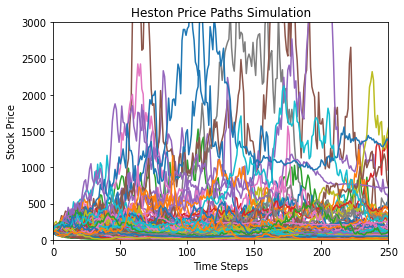

In [55]:
for i in range(steps):
    plt.plot(prices[i,:])
    plt.title('Heston Price Paths Simulation')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.axis([0,250, 0,3000])

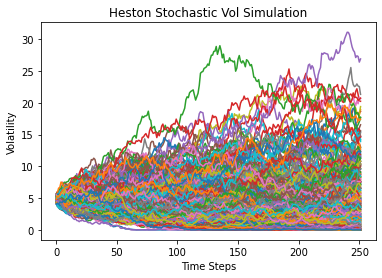

In [56]:
for i in range(steps):
    plt.plot(volatilities[i,:])
    plt.title('Heston Stochastic Vol Simulation')
    plt.xlabel('Time Steps')
    plt.ylabel('Volatility')

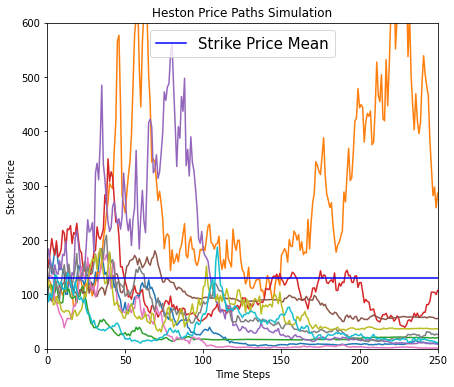

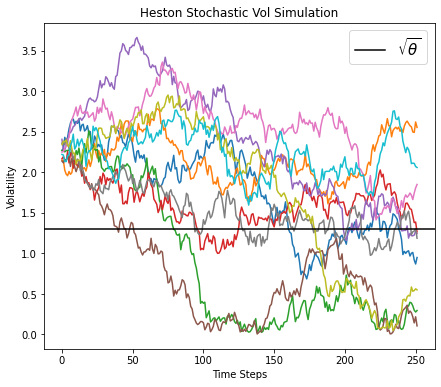

In [46]:
Npaths2 = 10
steps2 = 252
pricesej,sigsej = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho, xi, steps2, Npaths2,
                                    return_vol=True)        
    
plt.figure(figsize=(7,6))
plt.plot(pricesej.T)
plt.title('Heston Price Paths Simulation')
plt.axhline(y = 130, color='blue', label='Strike Price Mean')
plt.axis([0,250, 0, 600])
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend(fontsize=15)
plt.show()

plt.figure(figsize=(7,6))
plt.plot(np.sqrt(sigsej.T))
plt.axhline(np.sqrt(theta), color='black', label=r'$\sqrt{\theta}$')
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend(fontsize=15)
plt.show()

In [19]:
#Otra prueba
#un ciclo que genere K's distintas, por ejemplo del 1-20% hacia abajo y arriba partiendo del S_t 

def calculate_option_prices(S_t, K, T, r, sigma, type_='call'):
    d1 = (np.log(S_t / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if type_ == 'call':
        option_price = S_t * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif type_ == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S_t * norm.cdf(-d1)
    else:
        raise ValueError("type_ must be 'call' or 'put'")
    
    return option_price

k1 = np.linspace(S*.3, S*1.7, num = 20)

In [20]:
# Inicializa listas vacías para almacenar los precios de opciones para cada valor de K
call_prices = []
put_prices = []

# Itera sobre cada valor de K en k1 y calcula los precios de las opciones
for K_value in k1:
    call_prices_for_K = [calculate_option_prices(S, K_value, T, r, volatilities[i, -1], type_='call') for i in range(Npaths)]
    put_prices_for_K = [calculate_option_prices(S, K_value, T, r, volatilities[i, -1], type_='put') for i in range(Npaths)]
    
    call_prices.append(call_prices_for_K)  # Agrega la lista de precios de calls para el valor de K actual
    put_prices.append(put_prices_for_K)    # Agrega la lista de precios de puts para el valor de K actual


In [21]:
# Crear un diccionario con los datos
data = {
    'K_value': k1,
    'Call_Prices': call_prices,
    'Put_Prices': put_prices
}

# Crear un DataFrame a partir del diccionario
df2 = pd.DataFrame(data)

# Mostrar el DataFrame (opcional)
df2

,K_value,Call_Prices,Put_Prices
0,38.477998,"[128.24463139646642, 128.25998914779774, 128.1...","[36.447219709647634, 36.46257746097895, 36.391..."
1,47.928735,"[128.24277733978812, 128.259988513463, 128.180...","[45.40108774911389, 45.41829892278877, 45.3385..."
2,57.379471,"[128.24110354536114, 128.2599879400057, 128.17...","[54.35513605083149, 54.374020445476056, 54.286..."
3,66.830208,"[128.23956729673006, 128.25998741291968, 128.1...","[63.309321898344976, 63.32974201453462, 63.235..."
4,76.280944,"[128.23814047408803, 128.25998692268075, 128.1...","[72.2636171718475, 72.28546362044024, 72.18411..."
5,85.731681,"[128.2368033963606, 128.25998646263616, 128.15...","[81.21800219026466, 81.2411852565402, 81.13361..."
6,95.182417,"[128.23554164986814, 128.25998602792134, 128.1...","[90.17246253991675, 90.19690691796993, 90.0834..."
7,104.633153,"[128.23434430297868, 128.25998561485144, 128.1...","[99.12698728917185, 99.15262860104461, 99.0336..."
8,114.083890,"[128.23320283105903, 128.25998522055596, 128.1...","[108.08156791339678, 108.10835030289368, 107.9..."
9,123.534626,"[128.23211043402517, 128.25998484274697, 128.1...","[117.0361976125075, 117.0640720212293, 116.934..."


In [43]:
np.mean(k1)

128.25999450683594

Text(0, 0.5, 'Density')

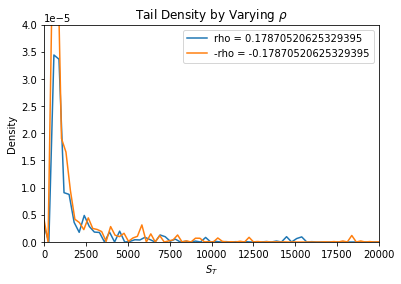

In [23]:
prices_pos = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=rhoSV, xi=sigmaV, steps=steps, Npaths=Npaths,#rho positiva
                                    return_vol=False)[:,-1]  
prices_neg  = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=-rhoSV, xi=sigmaV, steps=steps, Npaths=Npaths,#rho negativa
                                    return_vol=False)[:,-1]    


fig, ax = plt.subplots()

ax = sns.kdeplot(data=prices_pos, label=f"rho = {rhoSV}", ax=ax)
ax = sns.kdeplot(data=prices_neg, label=f"-rho = {-rhoSV}", ax=ax)

ax.set_title(r'Tail Density by Varying $\rho$')
plt.axis([0, 20000, 0, 0.00004])
plt.xlabel('$S_T$')
plt.ylabel('Density')

In [24]:
def implied_vol(opt_value, S, K, T, r, type_='call'):
    def option_obj(sigma):
        if type_ == 'call':
            option_price = calculate_option_prices(S, K, T, r, sigma, type_='call')
        elif type_ == 'put':
            option_price = calculate_option_prices(S, K, T, r, sigma, type_='put')
        else:
            raise ValueError("type_ must be 'put' or 'call'")
        
        return abs(option_price - opt_value)

    # Ajusta los límites según tus necesidades
    bounds = (0.01, 6)
    
    res = minimize_scalar(option_obj, bounds=bounds, method='bounded')
    return res.x


In [25]:
# Inicializar listas para almacenar los resultados
iv_values_call = []
iv_values_put = []

# Recorre cada valor de K en k1
for K_value in k1:
    C = calculate_option_prices(S, K_value, T, r, xi, type_='call')
    iv_call = implied_vol(C, S, K_value, T, r)
    iv_values_call.append(iv_call)

    P = calculate_option_prices(S, K_value, T, r, xi, type_='put')
    iv_put = implied_vol(P, S, K_value, T, r, type_='put')
    iv_values_put.append(iv_put)

In [26]:
iv_values_call

[2.286172278040106,
 2.2861700173728754,
 2.286172982076109,
 2.2861716218765875,
 2.2861719264600717,
 2.286171928976104,
 2.2861721763831375,
 2.2861712987092733,
 2.286170364363073,
 2.2861730436562264,
 2.286173838704447,
 2.2861695320690325,
 2.286172303627558,
 2.2861701929949603,
 2.28617032633265,
 2.286171423884696,
 2.2861704139591335,
 2.286171114661753,
 2.286170712739149,
 2.2861715899982333]

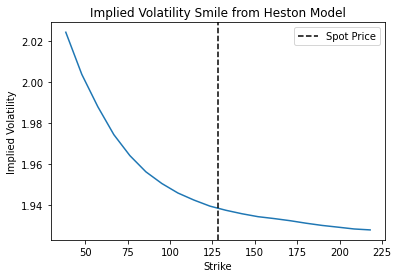

In [27]:
strikes = k1

puts = [] 

for L in strikes:
    P = np.mean(np.maximum(L-prices_neg,0))*np.exp(-r*T)
    puts.append(P)


ivs = [implied_vol(P, S, L, T, r, type_ = 'put' ) for P, L in zip(puts,strikes)]

plt.plot(strikes, ivs)
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.axvline(S, color='black',linestyle='--',
            label='Spot Price')
plt.title('Implied Volatility Smile from Heston Model')
plt.legend()

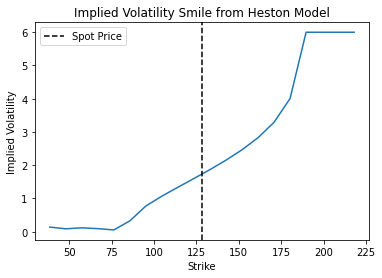

In [28]:
strikes = k1

calls = [] 

for L in strikes:
    Ca = np.mean(np.maximum(prices_pos-L,0))*np.exp(-r*T)
    calls.append(Ca)


ivs = [implied_vol(Ca, S, L, T, r, type_ = 'call' ) for Ca, L in zip(calls,strikes)]

plt.plot(strikes, ivs)
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.axvline(S, color='black',linestyle='--',
            label='Spot Price')
plt.title('Implied Volatility Smile from Heston Model')
plt.legend()

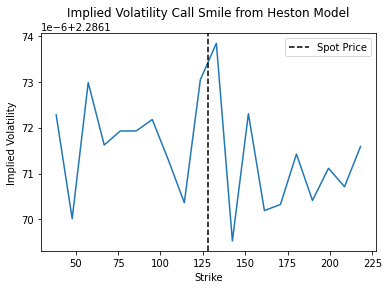

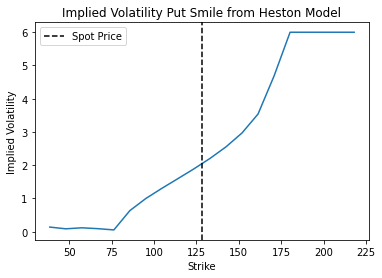

In [29]:
# Valores de los precios de ejercicio
strikes = k1

# Calcula las opciones de compra o venta para cada valor de precio de ejercicio y obtiene las volatilidades implícitas
iv_values_c = []
iv_values_p = []
for K_value in strikes:
    C = calculate_option_prices(S, K_value, T, r, xi, type_='call')
    Pu = calculate_option_prices(S, K_value, T, r, xi, type_='put')
    iv_call = implied_vol(C, S, K_value, T, r)
    iv_values_c.append(iv_call)
    iv_put = implied_vol(Pu, S, K_value, T, r)
    iv_values_p.append(iv_put)
    
# Grafica la volatilidad implícita
plt.plot(strikes, iv_values_c)
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.axvline(S, color='black', linestyle='--', label='Spot Price')
plt.title('Implied Volatility Call Smile from Heston Model')
plt.legend()
plt.show()

plt.plot(strikes, iv_values_p)
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.axvline(S, color='black', linestyle='--', label='Spot Price')
plt.title('Implied Volatility Put Smile from Heston Model')
plt.legend()
plt.show()
